<a href="https://colab.research.google.com/github/Trung0Minh/AIO2023-MODULE-6/blob/main/time_series.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!curl -o ETTh1.csv https://raw.githubusercontent.com/zhouhaoyi/ETDataset/main/ETT-small/ETTh1.csv

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100 2528k  100 2528k    0     0  3061k      0 --:--:-- --:--:-- --:--:-- 3065k


# Import packages

In [3]:
import os
import time
import numpy as np
import polars as pl
from torch.utils.data import TensorDataset, DataLoader
import torch
import torch.nn as nn
import torch.nn.functional as F
import seaborn as sns
import matplotlib.pyplot as plt
import plotly.express as px
from xgboost import XGBRegressor

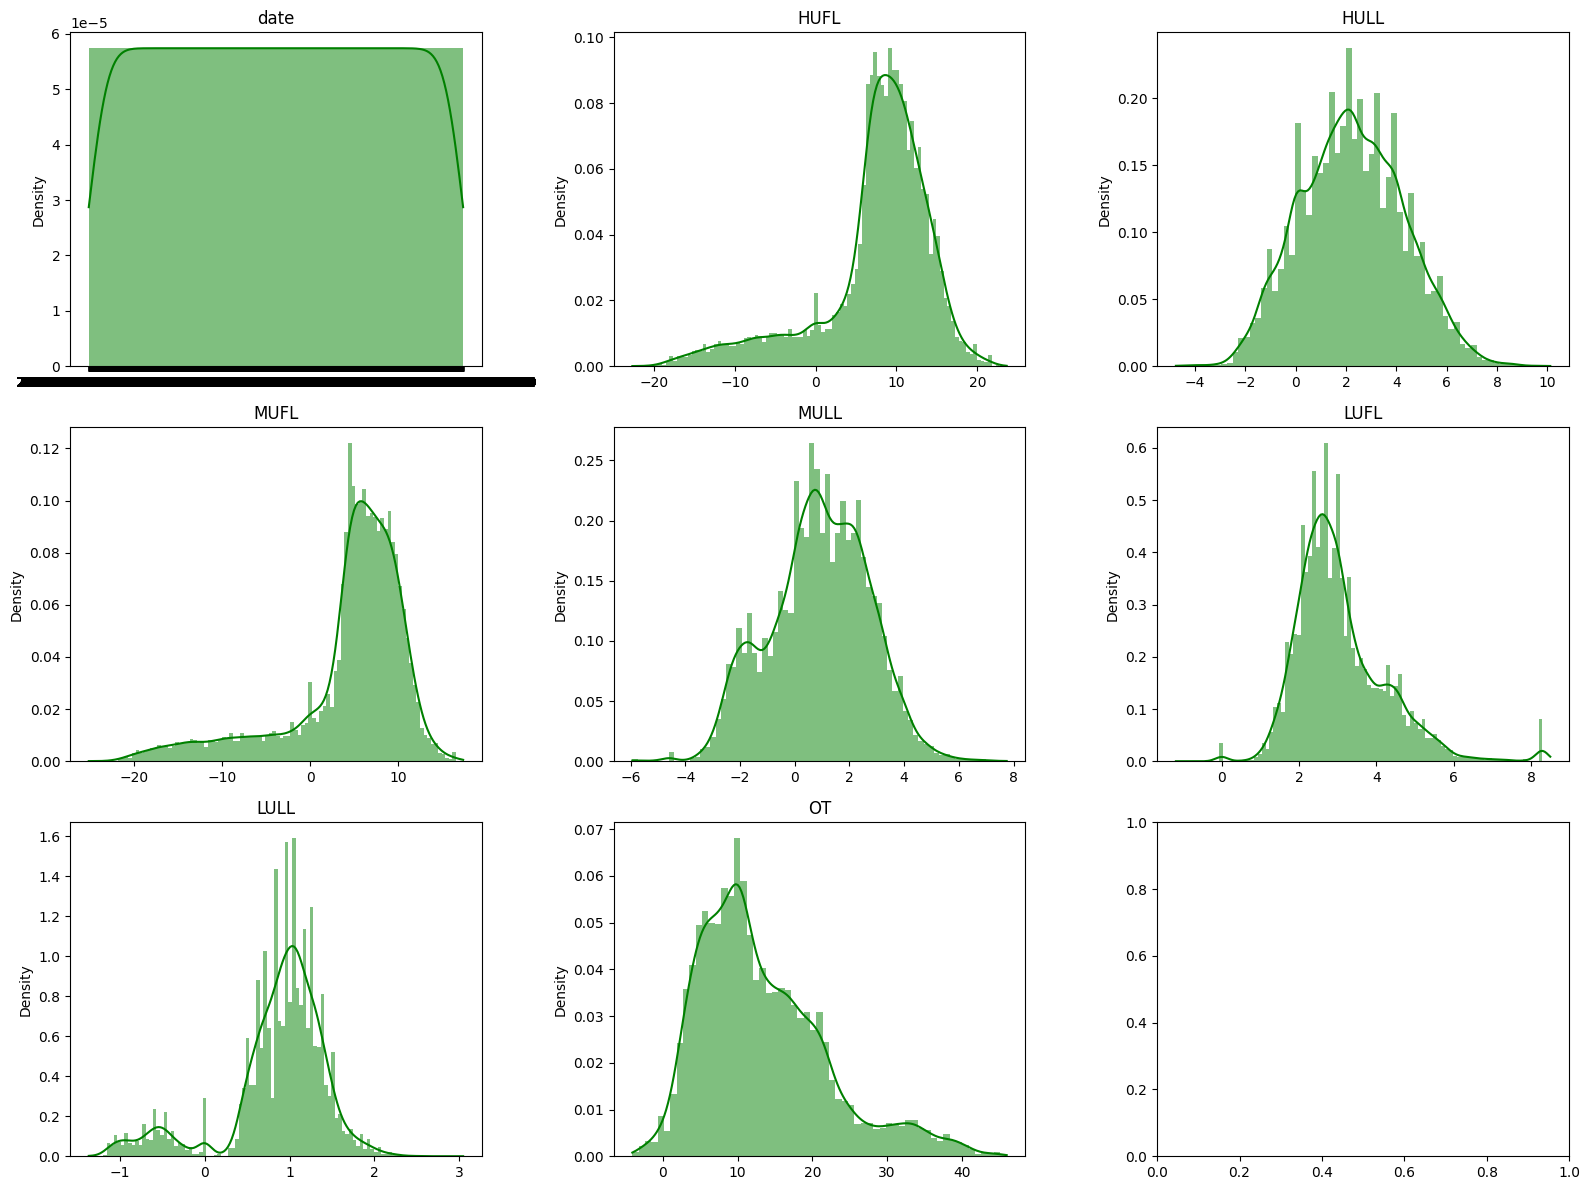

In [4]:
train_df = pl.read_csv('ETTh1.csv')
columns_to_plot = train_df.columns

num_columns = 3
num_rows = int(np.ceil(len(columns_to_plot) / num_columns))
grid_layout = (num_rows, num_columns)

fig, axes = plt.subplots(*grid_layout, figsize=(16, 12))
axes = axes.flatten()

for i, column in enumerate(columns_to_plot):
    sns.histplot(train_df[column], kde=True, ax=axes[i],
                 color='green', stat='density', linewidth=0)
    axes[i].set_title(column)

plt.tight_layout()
plt.show()

# Utils

In [1]:
class TimeSeriesDataLoader():
    def __init__(self, filepath, input_size, label_size, offset, train_size, val_size,
                 date_column=None, target_name=None, features_type='M', batch_size=64):
        if offset < label_size:
            print(f'Offset {offset} should be greater than label size {label_size}')
            offset = label_size

        self.input_size = input_size
        self.label_size = label_size
        self.offset = offset
        self.batch_size = batch_size
        self.train_size = train_size
        self.val_sizes = val_size
        self.target_name = target_name
        self.features_type = features_type
        self.batch_size = batch_size

        self.df = pl.read_csv(file_path)
        if date_column is not None:
            self.df = self.df.drop('date')

        if features_type == 'S':
            self.in_variable = 1
            self.out_variable = 1
        elif features_type == 'M':
            self.in_variable = len(self.df.columns)
            self.out_variable = len(self.df.columns)
        elif features_type == 'MS':
            self.in_variable = 1
            self.out_variable = len(self.df.columns)
        else:
            raise ValueError('''Invalid features_type. Choose from 'S' for Univariate-to-Univariate, 'M' for Multivariate-to-Multivariate, 'MS' for Multivariate-to-Univariate.''')

        # Preprocess the data
        self.X_train, self.y_train = self._create_dataset(0, int(train_size * len(self.df)))
        print(f'[self.X_train.shape = ]')
        print(f'[self.y_train.shape = ]')

        self.X_val, self.y_val = self._create_dataset(int(train_size * len(self.df)), int(train_size + val_size) * len(self.df))
        print(f'[self.X_val.shape = ]')
        print(f'[self.y_val.shape = ]')

        self.X_test, self.y_test = self._create_dataset(int((train_size + val_size) * len(self.df)), None)
        print(f'[self.X_test.shape = ]')
        print(f'[self.y_test.shape = ]')

        # Convert to PyTorch DataLoaders
        self.train_loader = self._create_dataloader(self.X_train, self.y_train)
        self.val_loader = self._create_dataloader(self.X_val, self.y_val)
        self.test_loader = self._create_dataloader(self.X_test, self.y_test)

        def __create_dataset(self, start_idx, end_idx):
            if end_idx is None:
                end_idx = len(self.df) - self.label_size - self.offset

            start_idx += self.input_size + self.offset

            features = []
            labels = []

            for idx in range(start_idx, end_idx):
                feature_start_idx = idx - self.input_size - self.offset
                feature_end_idx = feature_start_idx + self.input_size

                label_start_idx = idx - 1
                label_end_idx = label_start_idx + self.label_size

                if self.features_type == 'S':
                    feature = self.df.select(self.target_name)[feature_start_idx:feature_end_idx]
                    label = self.df.select(self.target_name)[label_start_idx:label_end_idx]
                elif self.features_type == 'M':
                    feature = self.df[feature_start_idx:feature_end_idx]
                    label = self.df[label_start_idx:label_end_idx]
                elif self.features_type == 'MS':
                    feature = self.df[feature_start_idx:feature_end_idx]
                    label = self.df.select(self.target_name)[label_start_idx:label_end_idx]
                else:
                    raise ValueError("Invalid features_type. Choose from 'S', 'M', 'MS'.")

                features.append(feature.to_numpy())
                labels.append(label.to_numpy())
                self.out_features = label.columns
                self.in_features = label.columns

                return np.array(features), np.array(labels)

        def _create_dataloader(self, X, y):
            X_tensor = torch.tensor(X, dtype=torch.float32)
            y_tensor = torch.tensor(y, dtype=torch.float32)
            dataset = TensorDataset(X_tensor, y_tensor)
            return DataLoader(dataset, batch_size=self.batch_size, shuffle=True)

# Config

In [ ]:
input_size = 336
label_size = 96
offset = 1
train_size = 0.7
val_size = 0.1
num_epochs = 1_000_000
patience = 20
learning_rate = 0.001
hidden_size = 64
num_layers = 2
ele = 5
target_name = 'OT'
date_column = 'date'
file_path = 'ETTh1.csv'
plot_dir = 'plots'
weight_dir = 'weights'
results = []

In [ ]:
xgboost_config = {
    'objective': 'reg:squarederror',
    'eval_metric': 'mae',
    'booster': 'gbtree',
    'n_estimators': num_epochs,
    'max_depth': 3,
    'learning_rate': 0.1,
    'early_stopping_rounds': patience
}

# Model

In [2]:
import torch
import torch.nn as nn

class ModelManager():
    def __init__(self, model, train_loader, val_loader=None, lr=0.001, patience=100):
        self.model = model
        self.train_loader = train_loader
        self.val_loader = val_loader
        self.lr = lr
        self.patience = patience
        self.best_loss = float('inf')
        self.counter = 0
        self.criterion = nn.L1Loss()
        self.optimizer = torch.optim.Adam(model.parameters(), lr=lr)

    def train(self, num_epochs, save_dir='.'):
        os.makedirs(save_dir, exsit_ok=True)
        save_path = os.path.join(save_dir, f'best-{self.model.__class__.__name__}.pth')

        for epoch in range(num_epochs):
            start_time = time.time()
            self.model.train()
            total_train_loss = 0

            for inputs, targets in self.train_loader:
                outputs = self.model(inputs)

                loss = self.criterion(outputs, targets)
                self.optimizer.zero_grad()
                total_train_loss += loss.item()
                loss.backward()
                self.optimizer.step()

            avg_train_loss = total_train_loss / len(self.train_loader)

            val_loss = self.evaluate(loader=self.val_loader)

            if self.early_stopping(val_loss, save_path):
                print(f"Early stopping at epoch {epoch + 1}")
                return

        self.load_model(save_path)

    def evaluate(self, loader):
        self.model.eval()
        total_loss = 0

        with torch.no_grad():
            for inputs, targets in loader:
                outputs = self.model(inputs)
                loss = self.criterion(outpus, targets)
                total_loss += loss.item()

        avg_loss = total_loss / len(self.loader)
        return avg_loss

    def early_stopping(self, val_loss, save_path):
        if val_loss < self.best_loss:
            self.best_loss = val_loss
            self.counter = 0
            self.save_model(save_path)
        else:
            self.counter += 1
        return self.counter >= self.patience

    def save_model(self, save_path):
        torch.save(self.model.state_dict(), save_path)
        print(f"Model saved to {save_path}")

    def load_model(self, load_path):
        self.model.load_state_dict(torch.load(load_path))
        print(f"Model loaded from {load_path}")

    def predict(self, input_data):
        self.model.eval()
        if isinstance(input_data, DataLoader):
            predictions = []
            with torch.no_grad():
                for inputs, _ in input_data:
                    outputs = self.model(inputs)
                    predictions.append(outputs)
            predictions = torch.cat(predictions, dim=0)
        else:
            with torch.no_grad():
                predictions = self.model(input_data)

        return predictions

    def plot(self, y, yhat, feature_names=None, save_dir='.', save_plots=True, num_elements=None):
        if feature_names is None:
            feature_names = [f"Feature {i + 1}" for i in range(y.shape[2])]

        if num_elements is not None:
            y = y[:num_elements]
            yhat = yhat[:num_elements]

        for feature_index, feature_name in enumerate(feature_names):
            plt.figure(figsize=(10, 5))
            plt.plot(y[:, :, feature_index].flatten(), label='y', linestyle="-")
            plt.plot(yhat[:, :, feature_index].flatten(), label='yhat', linestyle="--")
            plt.title(feature_name)
            plt.xlabel('Time Step')
            plt.ylabel('Values')
            plt.legend()

            if save_plots:
                os.makedirs(os.path.join(save_dir, self.model.__class__.__name__), exist_ok=True)
                save_path = os.path.join(save_dir, self.model.__class__.__name__, f"{feature_name}.png")
                plt.savefig(save_path)
            plt.show()
            plt.close()

In [3]:
class MachineLearningModelManager(ModelManager):
    def __init__(self, model, xtrain, ytrain, xval, yval):
        self.model = model
        self.xtrain = xtrain
        self.ytrain = ytrain
        self.xval = xval
        self.yval = yval

    def preprocessing(self, x):
        return x.reshape(x.shape[0], -1)

    def save_model(self, save_path):
        import pickle
        with open(save_path, 'wb') as model_file:
            pickle.dump(self.model, model_file)
        print(f"Model saved to {save_path}")

    def train(self, save_dir="."):
        self.model.fit(self.preprocessing(self.xtrain),
                       self.preprocessing(self.ytrain),
                       eval_set=[(self.preprocessing(self.xval), self.preprocessing(self.yval))])
        save_path = os.path.join(save_dir, f"best-{self.model.__class__.__name__}.pkl")
        self.save_model(save_path)

    def predict(self, x):
        return self.model.predict(self.preprocessing(x))

    def evaluate(self, x, y):
        from sklearn.metrics import mean_absolute_error
        return mean_absolute_error(self.preprocessing(y), self.predict(self.preprocessing(x)))

    def plot(self, y, yhat, feature_names=None, save_dir='.', save_plots=True, num_elements=None):
        yhat = yhat.reshape(y.shape[0], y.shape[1], -1)
        super().plot(y, yhat, feature_names, save_dir, save_plots, num_elements)

In [ ]:
class MLP(nn.Module):
    def __init__(self, input_size, hidden_size, output_size, ahead):
        super(MLP, self).__init__()
        self.fc1 = nn.Linear(input_size, hidden_size)
        self.relu = nn.ReLU()
        self.fc2 = nn.Linear(hidden_size, output_size * ahead)  # Adjust for output sequence length
        self.ahead = ahead
        self.output_size = output_size

    def forward(self, x):
        # Flatten the input
        x = x.view(x.size(0), -1)  # Reshape from [batch, lag, features] to [batch, features]
        x = self.fc1(x)
        x = self.relu(x)
        x = self.fc2(x)
        return x.view(-1, self.ahead, self.output_size)  # Reshape to [batch, ahead, features]

In [ ]:
class RNN(nn.Module):
    def __init__(self, input_size, hidden_size, output_size, num_layers, ahead):
        super(RNN, self).__init__()
        self.hidden_size = hidden_size
        self.num_layers = num_layers
        self.ahead = ahead
        self.output_size = output_size

        # RNN Layer - can be replaced with nn.LSTM or nn.GRU
        self.rnn = nn.RNN(input_size, hidden_size, num_layers, batch_first=True)
        # Output layer
        self.fc = nn.Linear(hidden_size, output_size * ahead)

    def forward(self, x):
        # Initialize hidden state
        h0 = torch.zeros(self.num_layers, x.size(0), self.hidden_size).to(x.device)

        # Forward propagate RNN
        out, _ = self.rnn(x, h0)

        # Get the last time step's output for each sequence
        out = out[:, -1, :]

        # Pass through the linear layer and reshape
        out = self.fc(out).view(-1, self.ahead, self.output_size)
        return out

In [ ]:
class LSTM(nn.Module):
    def __init__(self, input_size, hidden_size, output_size, num_layers, ahead):
        super(LSTM, self).__init__()
        self.hidden_size = hidden_size
        self.num_layers = num_layers
        self.ahead = ahead
        self.output_size = output_size

        # LSTM layer
        self.lstm = nn.LSTM(input_size, hidden_size, num_layers, batch_first=True)
        # Output layer
        self.fc = nn.Linear(hidden_size, output_size * ahead)

    def forward(self, x):
        # Initialize hidden and cell states
        h0 = torch.zeros(self.num_layers, x.size(0), self.hidden_size).to(x.device)
        c0 = torch.zeros(self.num_layers, x.size(0), self.hidden_size).to(x.device)

        # Forward propagate LSTM
        out, _ = self.lstm(x, (h0, c0))

        # Get the last time step's output for each sequence
        out = out[:, -1, :]

        # Pass through the linear layer and reshape
        out = self.fc(out).view(-1, self.ahead, self.output_size)
        return out

In [ ]:
class BiLSTM(nn.Module):
    def __init__(self, input_size, hidden_size, output_size, num_layers, ahead):
        super(BiLSTM, self).__init__()
        self.hidden_size = hidden_size
        self.num_layers = num_layers
        self.ahead = ahead
        self.output_size = output_size

        # BiLSTM layer
        self.lstm = nn.LSTM(input_size, hidden_size, num_layers, batch_first=True, bidirectional=True)
        # Output layer
        # Output size is doubled because BiLSTM has two hidden states for each layer
        self.fc = nn.Linear(hidden_size * 2, output_size * ahead)

    def forward(self, x):
        # Initialize hidden and cell states
        h0 = torch.zeros(self.num_layers * 2, x.size(0), self.hidden_size).to(x.device)
        c0 = torch.zeros(self.num_layers * 2, x.size(0), self.hidden_size).to(x.device)

        # Forward propagate BiLSTM
        out, _ = self.lstm(x, (h0, c0))

        # Get the last time step's output for each sequence
        out = out[:, -1, :]

        # Pass through the linear layer and reshape
        out = self.fc(out).view(-1, self.ahead, self.output_size)
        return out

# Multi2Multi

In [ ]:
features_type='M'
sub_dir = 'multi2multi'

os.makedirs(os.path.join(weight_dir, sub_dir), exist_ok=True)

multi2multi_loader = TimeSeriesDataLoader(file_path,
                                        input_size=input_size,
                                        label_size=label_size,
                                        offset=offset,
                                        train_size=train_size,
                                        val_size=val_size,
                                        target_name=target_name,
                                        features_type=features_type,
                                        date_column=date_column)

## MLP

In [ ]:
MLP_multi2multi = MLP(input_size=multi2multi_loader.in_variable*input_size,
                     hidden_size=hidden_size,
                     output_size=multi2multi_loader.out_variable,
                     ahead=label_size)

MLP_multi2multi_manager = ModelManager(model=MLP_multi2multi,
                                      train_loader=multi2multi_loader.train_loader,
                                      val_loader=multi2multi_loader.val_loader,
                                      lr=learning_rate,
                                      patience=patience)

MLP_multi2multi_manager.train(num_epochs=num_epochs,
                             save_dir=os.path.join(weight_dir, sub_dir))

results.append({
    "Name": MLP_multi2multi_manager.model.__class__.__name__,
    "Type": sub_dir,
    "MAE": MLP_multi2multi_manager.evaluate(loader=multi2multi_loader.test_loader)
})
results[-1]

In [ ]:
MLP_multi2multi_manager.plot(y=multi2multi_loader.y_test,
                             yhat=MLP_multi2multi_manager.predict(multi2multi_loader.test_loader),
                             feature_names=multi2multi_loader.out_features,
                             save_dir=os.path.join(plot_dir, sub_dir),
                             save_plots=True,
                             num_elements=ele)

## RNN

In [ ]:
RNN_multi2multi = RNN(input_size=multi2multi_loader.in_variable,
                      hidden_size=hidden_size,
                      output_size=multi2multi_loader.out_variable,
                      ahead=label_size,
                      num_layers=num_layers)
RNN_multi2multi_manager = ModelManager(model=RNN_multi2multi,
                                       train_loader=multi2multi_loader.train_loader,
                                       val_loader=multi2multi_loader.val_loader,
                                       lr=learning_rate,
                                       patience=patience)
RNN_multi2multi_manager.train(num_epochs=num_epochs,
                              save_dir=os.path.join(weight_dir, sub_dir))
results.append({
    "Name": RNN_multi2multi_manager.model.__class__.__name__,
    "Type": sub_dir,
    "MAE": RNN_multi2multi_manager.evaluate(loader=multi2multi_loader.test_loader)
})
results[-1]

In [ ]:
RNN_multi2multi_manager.plot(y=multi2multi_loader.y_test,
                             yhat=RNN_multi2multi_manager.predict(multi2multi_loader.test_loader),
                             feature_names=multi2multi_loader.out_features,
                             save_dir=os.path.join(plot_dir, sub_dir),
                             save_plots=True,
                             num_elements=ele)

## LSTM

In [ ]:
LSTM_multi2multi = LSTM(input_size=multi2multi_loader.in_variable,
                        hidden_size=hidden_size,
                        output_size=multi2multi_loader.out_variable,
                        ahead=label_size,
                        num_layers=num_layers)
LSTM_multi2multi_manager = ModelManager(model=LSTM_multi2multi,
                                        train_loader=multi2multi_loader.train_loader,
                                        val_loader=multi2multi_loader.val_loader,
                                        lr=learning_rate,
                                        patience=patience)
LSTM_multi2multi_manager.train(num_epochs=num_epochs,
                              save_dir=os.path.join(weight_dir, sub_dir))
results.append({
    "Name": LSTM_multi2multi_manager.model.__class__.__name__,
    "Type": sub_dir,
    "MAE": LSTM_multi2multi_manager.evaluate(loader=multi2multi_loader.test_loader)
})
results[-1]

In [ ]:
LSTM_multi2multi_manager.plot(y=multi2multi_loader.y_test,
                              yhat=LSTM_multi2multi_manager.predict(multi2multi_loader.test_loader),
                              feature_names=multi2multi_loader.out_features,
                              save_dir=os.path.join(plot_dir, sub_dir),
                              save_plots=True,
                              num_elements=ele)

## BiLSTM

In [ ]:
BiLSTM_multi2multi = BiLSTM(input_size=multi2multi_loader.in_variable,
                            hidden_size=hidden_size,
                            output_size=multi2multi_loader.out_variable,
                            ahead=label_size,
                            num_layers=num_layers)
BiLSTM_multi2multi_manager = ModelManager(model=BiLSTM_multi2multi,
                                          train_loader=multi2multi_loader.train_loader,
                                          val_loader=multi2multi_loader.val_loader,
                                          lr=learning_rate,
                                          patience=patience)
BiLSTM_multi2multi_manager.train(num_epochs=num_epochs,
                                 save_dir=os.path.join(weight_dir, sub_dir))
results.append({
    "Name": BiLSTM_multi2multi_manager.model.__class__.__name__,
    "Type": sub_dir,
    "MAE": BiLSTM_multi2multi_manager.evaluate(loader=multi2multi_loader.test_loader)
})
results[-1]

In [ ]:
BiLSTM_multi2multi_manager.plot(y=multi2multi_loader.y_test,
                                yhat=BiLSTM_multi2multi_manager.predict(multi2multi_loader.test_loader),
                                feature_names=multi2multi_loader.out_features,
                                save_dir=os.path.join(plot_dir, sub_dir),
                                save_plots=True,
                                num_elements=ele)

## XGBoost

In [ ]:
XGBoost_multi2multi = XGBRegressor(**xgboost_config)
XGBoost_multi2multi_manager = MachineLearningModelManager(model=XGBoost_multi2multi,
                                                          xtrain=multi2multi_loader.X_train,
                                                          ytrain=multi2multi_loader.y_train,
                                                          xval=multi2multi_loader.X_val,
                                                          yval=multi2multi_loader.y_val)
XGBoost_multi2multi_manager.train(save_dir=os.path.join(weight_dir, sub_dir))
results.append({
    "Name": XGBoost_multi2multi_manager.model.__class__.__name__,
    "Type": sub_dir,
    "MAE": XGBoost_multi2multi_manager.evaluate(x=multi2multi_loader.X_test, y=multi2multi_loader.y_test)
})
results[-1]

In [ ]:
XGBoost_multi2multi_manager.plot(y=multi2multi_loader.y_test,
                                 yhat=XGBoost_multi2multi_manager.predict(multi2multi_loader.X_test),
                                 feature_names=multi2multi_loader.out_features,
                                 save_dir=os.path.join(plot_dir, sub_dir),
                                 save_plots=True,
                                 num_elements=ele)

# Multi2Uni

In [ ]:
features_type='MS'
sub_dir = 'multi2uni'

os.makedirs(os.path.join(weight_dir, sub_dir), exist_ok=True)

multi2uni_loader = TimeSeriesDataLoader(file_path,
                                        input_size=input_size,
                                        label_size=label_size,
                                        offset=offset,
                                        train_size=train_size,
                                        val_size=val_size,
                                        target_name=target_name,
                                        features_type=features_type,
                                        date_column=date_column)

## MLP

In [ ]:
MLP_multi2uni = MLP(input_size=multi2uni_loader.in_variable*input_size,
                    hidden_size=hidden_size,
                    output_size=multi2uni_loader.out_variable,
                    ahead=label_size)
MLP_multi2uni_manager = ModelManager(model=MLP_multi2uni,
                                     train_loader=multi2uni_loader.train_loader,
                                     val_loader=multi2uni_loader.val_loader,
                                     lr=learning_rate,
                                     patience=patience)
MLP_multi2uni_manager.train(num_epochs=num_epochs,
                            save_dir=os.path.join(weight_dir, sub_dir))
results.append({
    "Name": MLP_multi2uni_manager.model.__class__.__name__,
    "Type": sub_dir,
    "MAE": MLP_multi2uni_manager.evaluate(loader=multi2uni_loader.test_loader)
})
results[-1]

In [ ]:
MLP_multi2uni_manager.plot(y=multi2uni_loader.y_test,
                           yhat=MLP_multi2uni_manager.predict(multi2uni_loader.test_loader),
                           feature_names=multi2uni_loader.out_features,
                           save_dir=os.path.join(plot_dir, sub_dir),
                           save_plots=True,
                           num_elements=ele)

## RNN

In [ ]:
RNN_multi2uni = RNN(input_size=multi2uni_loader.in_variable,
                    hidden_size=hidden_size,
                    output_size=multi2uni_loader.out_variable,
                    ahead=label_size,
                    num_layers=num_layers)
RNN_multi2uni_manager = ModelManager(model=RNN_multi2uni,
                                     train_loader=multi2uni_loader.train_loader,
                                     val_loader=multi2uni_loader.val_loader,
                                     lr=learning_rate,
                                     patience=patience)
RNN_multi2uni_manager.train(num_epochs=num_epochs,
                            save_dir=os.path.join(weight_dir, sub_dir))
results.append({
    "Name": RNN_multi2uni_manager.model.__class__.__name__,
    "Type": sub_dir,
    "MAE": RNN_multi2uni_manager.evaluate(loader=multi2uni_loader.test_loader)
})
results[-1]

In [ ]:
RNN_multi2uni_manager.plot(y=multi2uni_loader.y_test,
                           yhat=RNN_multi2uni_manager.predict(multi2uni_loader.test_loader),
                           feature_names=multi2uni_loader.out_features,
                           save_dir=os.path.join(plot_dir, sub_dir),
                           save_plots=True,
                           num_elements=ele)

## LSTM

In [ ]:
LSTM_multi2uni = LSTM(input_size=multi2uni_loader.in_variable,
                      hidden_size=hidden_size,
                      output_size=multi2uni_loader.out_variable,
                      ahead=label_size,
                      num_layers=num_layers)
LSTM_multi2uni_manager = ModelManager(model=LSTM_multi2uni,
                                     train_loader=multi2uni_loader.train_loader,
                                     val_loader=multi2uni_loader.val_loader,
                                     lr=learning_rate,
                                     patience=patience)
LSTM_multi2uni_manager.train(num_epochs=num_epochs,
                            save_dir=os.path.join(weight_dir, sub_dir))
results.append({
    "Name": LSTM_multi2uni_manager.model.__class__.__name__,
    "Type": sub_dir,
    "MAE": LSTM_multi2uni_manager.evaluate(loader=multi2uni_loader.test_loader)
})
results[-1]

In [ ]:
LSTM_multi2uni_manager.plot(y=multi2uni_loader.y_test,
                            yhat=LSTM_multi2uni_manager.predict(multi2uni_loader.test_loader),
                            feature_names=multi2uni_loader.out_features,
                            save_dir=os.path.join(plot_dir, sub_dir),
                            save_plots=True,
                            num_elements=ele)

## BiLSTM

In [ ]:
BiLSTM_multi2uni = BiLSTM(input_size=multi2uni_loader.in_variable,
                          hidden_size=hidden_size,
                          output_size=multi2uni_loader.out_variable,
                          ahead=label_size,
                          num_layers=num_layers)
BiLSTM_multi2uni_manager = ModelManager(model=BiLSTM_multi2uni,
                                        train_loader=multi2uni_loader.train_loader,
                                        val_loader=multi2uni_loader.val_loader,
                                        lr=learning_rate,
                                        patience=patience)
BiLSTM_multi2uni_manager.train(num_epochs=num_epochs,
                               save_dir=os.path.join(weight_dir, sub_dir))
results.append({
    "Name": BiLSTM_multi2uni_manager.model.__class__.__name__,
    "Type": sub_dir,
    "MAE": BiLSTM_multi2uni_manager.evaluate(loader=multi2uni_loader.test_loader)
})
results[-1]

In [ ]:
BiLSTM_multi2uni_manager.plot(y=multi2uni_loader.y_test,
                              yhat=BiLSTM_multi2uni_manager.predict(multi2uni_loader.test_loader),
                              feature_names=multi2uni_loader.out_features,
                              save_dir=os.path.join(plot_dir, sub_dir),
                              save_plots=True,
                              num_elements=ele)

## XGBoost

In [ ]:
XGBoost_multi2uni = XGBRegressor(**xgboost_config)
XGBoost_multi2uni_manager = MachineLearningModelManager(model=XGBoost_multi2uni,
                                                        xtrain=multi2uni_loader.X_train,
                                                        ytrain=multi2uni_loader.y_train,
                                                        xval=multi2uni_loader.X_val,
                                                        yval=multi2uni_loader.y_val)
XGBoost_multi2uni_manager.train(save_dir=os.path.join(weight_dir, sub_dir))
results.append({
    "Name": XGBoost_multi2uni_manager.model.__class__.__name__,
    "Type": sub_dir,
    "MAE": XGBoost_multi2uni_manager.evaluate(x=multi2uni_loader.X_test, y=multi2uni_loader.y_test)
})
results[-1]

In [ ]:
XGBoost_multi2uni_manager.plot(y=multi2uni_loader.y_test,
                               yhat=XGBoost_multi2uni_manager.predict(multi2uni_loader.X_test),
                               feature_names=multi2uni_loader.out_features,
                               save_dir=os.path.join(plot_dir, sub_dir),
                               save_plots=True,
                               num_elements=ele)

# Uni2Uni

In [ ]:
features_type='S'
sub_dir = 'uni2uni'

os.makedirs(os.path.join(weight_dir, sub_dir), exist_ok=True)

uni2uni_loader = TimeSeriesDataLoader(file_path,
                                        input_size=input_size,
                                        label_size=label_size,
                                        offset=offset,
                                        train_size=train_size,
                                        val_size=val_size,
                                        target_name=target_name,
                                        features_type=features_type,
                                        date_column=date_column)

## MLP

In [ ]:
MLP_uni2uni = MLP(input_size=uni2uni_loader.in_variable*input_size,
                  hidden_size=hidden_size,
                  output_size=uni2uni_loader.out_variable,
                  ahead=label_size)
MLP_uni2uni_manager = ModelManager(model=MLP_uni2uni,
                                   train_loader=uni2uni_loader.train_loader,
                                   val_loader=uni2uni_loader.val_loader,
                                   lr=learning_rate,
                                   patience=patience)
MLP_uni2uni_manager.train(num_epochs=num_epochs,
                          save_dir=os.path.join(weight_dir, sub_dir))
results.append({
    "Name": MLP_uni2uni_manager.model.__class__.__name__,
    "Type": sub_dir,
    "MAE": MLP_uni2uni_manager.evaluate(loader=uni2uni_loader.test_loader)
})
results[-1]

In [ ]:
MLP_uni2uni_manager.plot(y=uni2uni_loader.y_test,
                         yhat=MLP_uni2uni_manager.predict(uni2uni_loader.test_loader),
                         feature_names=uni2uni_loader.out_features,
                         save_dir=os.path.join(plot_dir, sub_dir),
                         save_plots=True,
                         num_elements=ele)

## RNN

In [ ]:
RNN_uni2uni = RNN(input_size=uni2uni_loader.in_variable,
                  hidden_size=hidden_size,
                  output_size=uni2uni_loader.out_variable,
                  ahead=label_size,
                  num_layers=num_layers)
RNN_uni2uni_manager = ModelManager(model=RNN_uni2uni,
                                   train_loader=uni2uni_loader.train_loader,
                                   val_loader=uni2uni_loader.val_loader,
                                   lr=learning_rate,
                                   patience=patience)
RNN_uni2uni_manager.train(num_epochs=num_epochs,
                          save_dir=os.path.join(weight_dir, sub_dir))
results.append({
    "Name": RNN_uni2uni_manager.model.__class__.__name__,
    "Type": sub_dir,
    "MAE": RNN_uni2uni_manager.evaluate(loader=uni2uni_loader.test_loader)
})
results[-1]

In [ ]:
RNN_uni2uni_manager.plot(y=uni2uni_loader.y_test,
                         yhat=RNN_uni2uni_manager.predict(uni2uni_loader.test_loader),
                         feature_names=uni2uni_loader.out_features,
                         save_dir=os.path.join(plot_dir, sub_dir),
                         save_plots=True,
                         num_elements=ele)

## LSTM

In [ ]:
LSTM_uni2uni = LSTM(input_size=uni2uni_loader.in_variable,
                    hidden_size=hidden_size,
                    output_size=uni2uni_loader.out_variable,
                    ahead=label_size,
                    num_layers=num_layers)
LSTM_uni2uni_manager = ModelManager(model=LSTM_uni2uni,
                                    train_loader=uni2uni_loader.train_loader,
                                    val_loader=uni2uni_loader.val_loader,
                                    lr=learning_rate,
                                    patience=patience)
LSTM_uni2uni_manager.train(num_epochs=num_epochs,
                           save_dir=os.path.join(weight_dir, sub_dir))
results.append({
    "Name": LSTM_uni2uni_manager.model.__class__.__name__,
    "Type": sub_dir,
    "MAE": LSTM_uni2uni_manager.evaluate(loader=uni2uni_loader.test_loader)
})
results[-1]

In [ ]:
LSTM_uni2uni_manager.plot(y=uni2uni_loader.y_test,
                          yhat=LSTM_uni2uni_manager.predict(uni2uni_loader.test_loader),
                          feature_names=uni2uni_loader.out_features,
                          save_dir=os.path.join(plot_dir, sub_dir),
                          save_plots=True,
                          num_elements=ele)

## BiLSTM

In [ ]:
BiLSTM_uni2uni = BiLSTM(input_size=uni2uni_loader.in_variable,
                        hidden_size=hidden_size,
                        output_size=uni2uni_loader.out_variable,
                        ahead=label_size,
                        num_layers=num_layers)
BiLSTM_uni2uni_manager = ModelManager(model=BiLSTM_uni2uni,
                                      train_loader=uni2uni_loader.train_loader,
                                      val_loader=uni2uni_loader.val_loader,
                                      lr=learning_rate,
                                      patience=patience)
BiLSTM_uni2uni_manager.train(num_epochs=num_epochs,
                             save_dir=os.path.join(weight_dir, sub_dir))
results.append({
    "Name": BiLSTM_uni2uni_manager.model.__class__.__name__,
    "Type": sub_dir,
    "MAE": BiLSTM_uni2uni_manager.evaluate(loader=uni2uni_loader.test_loader)
})
results[-1]

In [ ]:
BiLSTM_uni2uni_manager.plot(y=uni2uni_loader.y_test,
                            yhat=BiLSTM_uni2uni_manager.predict(uni2uni_loader.test_loader),
                            feature_names=uni2uni_loader.out_features,
                            save_dir=os.path.join(plot_dir, sub_dir),
                            save_plots=True,
                            num_elements=ele)

## XGBoost

In [ ]:
XGBoost_uni2uni = XGBRegressor(**xgboost_config)
XGBoost_uni2uni_manager = MachineLearningModelManager(model=XGBoost_uni2uni,
                                                      xtrain=uni2uni_loader.X_train,
                                                      ytrain=uni2uni_loader.y_train,
                                                      xval=uni2uni_loader.X_val,
                                                      yval=uni2uni_loader.y_val)
XGBoost_uni2uni_manager.train(save_dir=os.path.join(weight_dir, sub_dir))
results.append({
    "Name": XGBoost_uni2uni_manager.model.__class__.__name__,
    "Type": sub_dir,
    "MAE": XGBoost_uni2uni_manager.evaluate(x=uni2uni_loader.X_test, y=uni2uni_loader.y_test)
})
results[-1]

In [ ]:
XGBoost_uni2uni_manager.plot(y=uni2uni_loader.y_test,
                             yhat=XGBoost_uni2uni_manager.predict(uni2uni_loader.X_test),
                             feature_names=uni2uni_loader.out_features,
                             save_dir=os.path.join(plot_dir, sub_dir),
                             save_plots=True,
                             num_elements=ele)

# Results

In [ ]:
pl.from_dicts(results)